# Transfer Learning

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning.

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

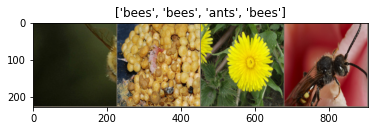

In [3]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# Visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

In [6]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5992 Acc: 0.6680
val Loss: 0.2710 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5123 Acc: 0.8033
val Loss: 0.3595 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4141 Acc: 0.8197
val Loss: 0.2825 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3851 Acc: 0.8484
val Loss: 0.2473 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4839 Acc: 0.7910
val Loss: 0.3023 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5668 Acc: 0.7787
val Loss: 0.3147 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5327 Acc: 0.7869
val Loss: 0.2474 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3071 Acc: 0.8730
val Loss: 0.2277 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2402 Acc: 0.8934
val Loss: 0.2426 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2646 Acc: 0.8811
val Loss: 0.2186 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2680 Acc: 0.8893
val Loss: 0.2306 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3065 Acc: 0.8607
val Loss: 0.2221 Acc: 0.9150

Ep

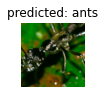

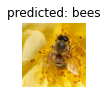

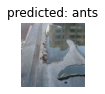

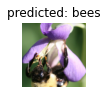

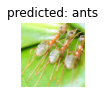

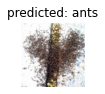

In [8]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5788 Acc: 0.6516
val Loss: 0.4524 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5409 Acc: 0.7787
val Loss: 0.3287 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4216 Acc: 0.8115
val Loss: 0.1729 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4717 Acc: 0.7623
val Loss: 0.1589 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5228 Acc: 0.7828
val Loss: 0.2106 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5306 Acc: 0.7951
val Loss: 0.1784 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3810 Acc: 0.8361
val Loss: 0.1935 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2621 Acc: 0.8975
val Loss: 0.1798 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2747 Acc: 0.8730
val Loss: 0.1811 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3310 Acc: 0.8648
val Loss: 0.1820 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3561 Acc: 0.8402
val Loss: 0.1792 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3832 Acc: 0.8525
val Loss: 0.1893 Acc: 0.9412

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()